<a href="https://colab.research.google.com/github/sonovman/DL_Term_PJT/blob/main/Tutorial_3_CNN_Edge_Detector_%EC%97%B0%EC%8A%B5_ipnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 라이브러리 로드

필요한 라이브러리를 로드해줍니다.

In [ ]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## 2. 데이터셋 로드

이번에도 [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 데이터를 사용할 예정입니다. 

CIFAR-10에 대한 데이터 살펴보기 예제는 [이 포스트](https://github.com/Intelligence-Engineering-LAB-KU/Deeplearning-Tutorial/blob/master/Tutorial%201%29%20CIFAR10_Softmax.ipynb)를 복습해주세요.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


1번 인덱스에 위치한 말 이미지를 불러와보겠습니다.

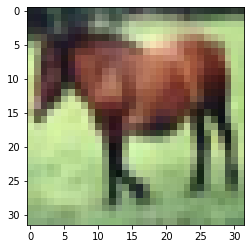

label:  [7]


In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[7].astype('uint8'), cmap=plt.cm.gray)
plt.show()

print('label: ', y_train[7])

### 3. Sobel Operator 복습

review: [지난 포스트](https://github.com/Intelligence-Engineering-LAB-KU/Deeplearning-Tutorial/blob/master/Tutorial_2_Sobel_Opearatior.ipynb)에서는 아래와 같은 Sobel opearatoin을 만들어 보았습니다. 

그러나 for loop 기반으로 동작하는 코드는 벡터 연산을 활용하는 코드보다 동작이 느립니다. 이번 예제에서는 

```python
from skimage.color import rgb2gray ## RGB 3채널 이미지를 흑백이미지로
from skimage.filters import sobel_h, sobel_v  ## sobel operator
```

위 라이브러리들을 이용하여 edge를 detection해볼 것입니다.

지난 포스트 방식과 큰 차이는 없지만, [padding](https://brunch.co.kr/@coolmindory/37) 기법이 추가되어 이미지의 사이즈가 이전과 달라지지 않으며,

결과값들이 0에서 1사이의 값을 가지도록 후처리를 한다는 점이 다릅니다. 

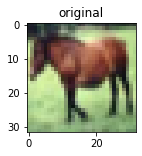

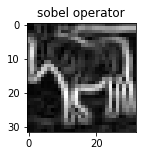

In [ ]:
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2gray

def sobel (image, thresold=180):
  grey_image = rgb2gray(image)
  convx = sobel_h(grey_image)
  convy = sobel_v(grey_image)
  output = np.sqrt(convx**2 + convy**2)
  return output

plt.figure(figsize=(2,2))
plt.imshow(x_train[7].astype('uint8'))
plt.title('original')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(sobel(x_train[7]), cmap=plt.cm.gray)
plt.title('sobel operator')
plt.show()

### 4. Sobel Opearator의 역할을 수행하는 Convolution Layer를 학습해보자.

4장에서는 Random으로 초기화된 Convolution Layer가 Sobel Operator와 같은 역할을 수행할 수 있는지 실험해보겠습니다. 

즉, 우리의 목적은 model(img)의 결과가 sobel_operator(img) 와 비슷해지도록 model을 학습하는 것입니다. 

그러기 위해 **Keras의 [Conv2d API]**(https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)를 이용하여 모델을 정의해보겠습니다. 

```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```
#### 4.1. 학습 데이터 구축

정답 데이터는 더 이상 레이블인 y_train, y_test가 아니라, edge 이미지입니다. 

따라서 다음과 같이 edge 이미지들을 만들어주겠습니다 

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

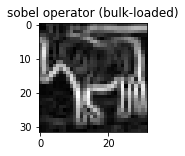

In [ ]:
sobel_train = np.array([sobel(img) for img in tqdm(x_train)])
sobel_test  = np.array([sobel(img) for img in tqdm(x_test)])

plt.figure(figsize=(2,2))
plt.imshow(sobel_train[7], cmap=plt.cm.gray)
plt.title('sobel operator (bulk-loaded)')
plt.show()

#### 4.2. 모델 정의

Sobel Operator는 먼저 gray scale로 이미지를 변환한 후, 두 개의 커널로 convolution 연산을 수행하고 

마지막으로 $G_{x}$ 와 $G_{y}$ 의 크기를 잽니다.

이 과정을 3계층의 Convolution Layer들이 모사한다고 가정하고 다음과 같은 모델을 만들어보겠습니다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU
from keras.regularizers import l1

tf.random.set_seed(2020)

model = Sequential([
    Conv2D(filters=2,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    Conv2D(filters=4,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    Conv2D(filters=1,kernel_size=(1,1), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
])

이제 총 $N$개의 이미지에 대해 
모델이 추정한 $i$번째 edge 이미지 $model(img_{i})$와 sobel operator의 결과물인 $G^{img_{i}}$ 사이의 차이를 정량화하기 위해, 다음과 같은 손실 함수를 사용한다고 가정해보겠습니다.

$MAE= \sum_{i}^N\sum_{p \in pixels}|model(img_{i})_{p}-G_{p}^{img_{i}}|$

Keras에서는 위 손실함수를 keras.losses.MeanAbsoluteError() 에서 지원합니다.

이제 아래와 같이 MAE 손실함수를 쓰며 Adam optimizer에 의해 최적화되는 모델을 컴파일해보겠습니다.

In [ ]:
## 학습가능한 필터를 가지고 있는 CNN으로 sobel operation을 학습해보자
model.compile(
          loss=keras.losses.MeanAbsoluteError(),
          optimizer=keras.optimizers.Adam())

훈련 전이므로, 다음과 같이 모델에 말 이미지를 넣으면 노이즈에 가까운 결과가 생성될 것입니다.

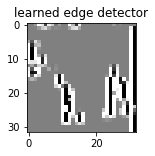

In [ ]:
def learned_edge_detection (model, img):
  return model(img.reshape(-1,32,32,3)).numpy()[0,:,:,0]
  
plt.figure(figsize=(2,2))
plt.imshow(learned_edge_detection(model, x_train[7]), cmap=plt.cm.gray)
plt.title('learned edge detector')
plt.show()

#### 4.3 모델 훈련

그렇다면, 이제 모델을 훈련시켜보겠습니다.


In [ ]:
model.fit(x_train, sobel_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, sobel_test),
          shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 54s 34ms/step - loss: 0.1375 - val_loss: 0.0699
Epoch 2/10
1563/1563 [==============================] - 51s 33ms/step - loss: 0.0678 - val_loss: 0.0659
Epoch 3/10
1563/1563 [==============================] - 55s 35ms/step - loss: 0.0648 - val_loss: 0.0634
Epoch 4/10
1563/1563 [==============================] - 56s 36ms/step - loss: 0.0622 - val_loss: 0.0611
Epoch 5/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.0603 - val_loss: 0.0596
Epoch 6/10
1563/1563 [==============================] - 54s 35ms/step - loss: 0.0540 - val_loss: 0.0493
Epoch 7/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.0473 - val_loss: 0.0462
Epoch 8/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.0455 - val_loss: 0.0445
Epoch 9/10
1563/1563 [==============================] - 53s 34ms/step - loss: 0.0440 - val_loss: 0.0432
Epoch 10/10
1563/1563 [==============================] - 48s 31m

훈련된 모델로 edge detector를 만들어 본 후, 이를 가시화해보겠습니다.

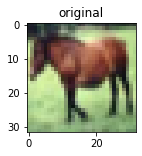

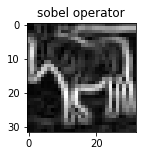

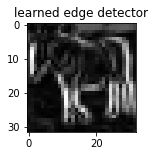

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(x_train[7].astype('uint8'))
plt.title('original')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(sobel(x_train[7]), cmap=plt.cm.gray)
plt.title('sobel operator')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(learned_edge_detection(model, x_train[7]), cmap=plt.cm.gray)
plt.title('learned edge detector')
plt.show()

#### 4.4 훈련 결과 확인해보기

훈련이 완료된 후에는 어느정도 말 이미지의 edge를 잘 찾아낸 것 같습니다!

이번에는 학습된 edge detector로 다양한 이미지의 edge를 찾아보겠습니다.

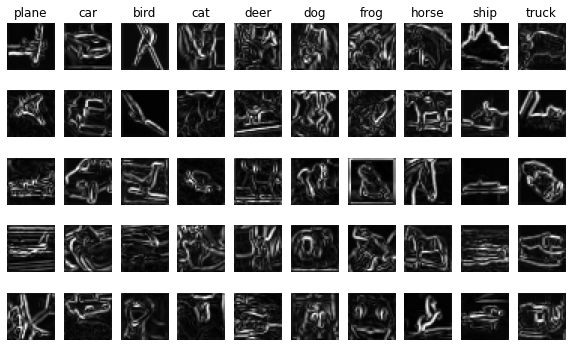

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(10,6))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(learned_edge_detection(model,x_train[idx]), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

#### 4.4 학습된 Weight 출력해보기

학습된 Weight들이 어떤지 출력해보겠습니다.

In [ ]:
print(model.weights)

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 2) dtype=float32, numpy=
array([[[[ 0.0038634 ,  0.01996917],
         [ 0.16726251,  0.04091756],
         [-0.05251146,  0.01751634]],

        [[ 0.0481553 , -0.00384884],
         [-0.09220104, -0.00551964],
         [ 0.02423647, -0.01040531]],

        [[-0.02154341,  0.01780056],
         [ 0.019071  ,  0.03109596],
         [ 0.03179552, -0.007085  ]]],


       [[[-0.02094819, -0.01210047],
         [-0.0288211 , -0.05418446],
         [ 0.07495975, -0.00675227]],

        [[-0.01904948, -0.05223108],
         [-0.06858996,  0.02048188],
         [-0.01512942,  0.01357931]],

        [[ 0.00417079,  0.0460779 ],
         [ 0.01067713,  0.0662417 ],
         [-0.06554719,  0.00777848]]],


       [[[ 0.0362543 , -0.00405847],
         [ 0.00334445, -0.01484378],
         [-0.03433523, -0.00783069]],

        [[-0.03568881,  0.00126421],
         [ 0.01635674, -0.1428456 ],
         [ 0.00765902, -0.02161768]],

        [[ 0.004304


## Reference

- [cs231n](http://cs231n.github.io/)
- [Keras tutorial on CIFAR-10](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)



---



## **[보충학습 : Convolution and correlation]**

2D에서 커널 K에 의한 프레임 X의 이산 컨벌루션은 다음과 같이 정의된다.

$S(i,j)=(X∗K)(i,j)=∑_m∑_n X(m,n)K(i−m,j−n) = ∑_m∑_n X(i−m,j−n)K(m,n)$

컨볼루션(Convolution)은 위의 방정식에서 볼 수 있는 것처럼 교환법칙의 성질을 갖는다.


그러나 상호 상관(Cross-correlation)은 매우 근사하지만 엄밀하게는 교환법칙이 적용되지 않는다.

$S_cc(i,j) = (X∗K)(i,j) = ∑_m∑_n X(i+m,j+n)K(m,n)$

또한 대부분의 경우 커널의 크기가 상당히 작다 (머칭러닝에서 3 x 3 ~ 7 x 7).

컨볼루션을 사용하는 것은 Dese Layer(퍼셉트론)를 사용하는 것과 같지만, 대부분의 계수를 공유한다. 이는 숫자 또는 매개변수(가중치)의 급격한 감소로 이어진다.

컨볼루션 커널은 독립적인 입력에 대한 변환 문제에 적합하다. 이것은 이미지 감지기 또는 필터로 일반적으로 사용된다.

<출처> https://tonio73.github.io/data-science/cnn/CnnEdgeDetection-Keras-Part1.html



---



## **[보충학습 : 이지미 처리 기법]**

RGB 색공간에서 색은 적(Red), 녹(Green), 청(Blue)의 3가지 색의 명도를 뜻하는 숫자 3개가 합쳐진 벡터로 표현된다. 8비트 부호없는 정수를 사용하는 경우 (255, 0, 0)은 빨간색, (0, 255, 0)은 녹색, (0, 0, 255)는 파란색이다.

픽셀 데이터가 스칼라가 아닌 벡터이므로 이미지 데이터는 (세로픽셀수 x 가로픽셀수) 형태의 2차원 배열로 표현하지 못하고 (세로픽셀수 x 가로픽셀수 x 색채널) 형태의 3차원 배열로 저장한다. 세번째 축을 색채널(channel)이라고 부른다.

본 튜터리얼에서 사용하는 학습 데이터는 3 채널(R,G,B)의 컬러의 CIFAR-10 데이터이다. 그러나 학습을 위한 정답 데이터는 그레이 스케일(1D)의 edge 이미지 데이터이어야 한다. 

따라서 레이블인 y_train, y_test를  "scikit-image"라는 이미지처리에 특화된 Python 이미지 라이브러리를 불러와 라벨링된 학습 데이터 y_train을 3채널 이미지를 흑백이미지로 변환하고 소버 필터를 적용하여 엣지이미지로 전처리하는 작업이 필수적이었다.

이와 관련하여 또 다른 방법이 없는지 조사해보았다.

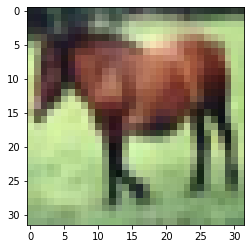

label:  [7]


In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[7].astype('uint8'), cmap=plt.cm.gray)
plt.show()

print('label: ', y_train[7])

이미 학습한 바와 같이 **Scikit-Image**는 그레이스케일, RGB, HSV 등의 색공간을 변환하는 기능을 color 서브패키지에서 제공한다.

[RGB to grayscale](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_rgb_to_gray.html#sphx-glr-auto-examples-color-exposure-plot-rgb-to-gray-py)

#### **OpenCV를 이용한 그레이 스케일의 단일 채널 변환 방법**

그레이스케일에서는 모든 색이 흑백이다. 각 픽셀은 명도를 나타내는 숫자로 표현된다. 0은 검은색을 나타내고 숫자가 커질수록 명도가 증가하여 하얀색이 된다. 숫자는 보통 0~255의 8비트 부호없는 정수로 저장된다. 

**[OpenCV]**

인텔이 처음 개발한 OpenCV는 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리이다. OpenCV에는 본래의 색상 공간에서 다른 색상 공간으로 변환할 수 있는 색상 공간 변환(Convert Color) 함수가 있다. 색상 공간 변환 함수는 데이터 타입을 같게 유지하고 채널을 변환한다.

**색상 공간 변환 함수(cv2.cvtcolor)로 이미지의 색상 공간을 변경할 수 있다**.

In [ ]:
import cv2
dst = cv2.cvtColor(x_train[7], cv2.COLOR_BGR2GRAY)

dst = cv2.cvtcolor(src, code, dstCn)는 입력 이미지(src), **색상 변환 코드(code)**, 출력 채널(dstCn)으로 출력 이미지(dst)을 생성한다. **색상 변환 코드(code)인  BGR2GRAY는 Blue, Green, Red 채널 이미지를 단일 채널, 그레이스케일 이미지로 변경힌다.**

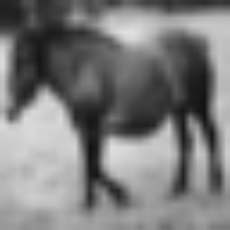

In [ ]:
cv2_imshow(cv2.resize(dst, (230, 230)))

cv2.imshow("src", dst)가 Colab에서 사용할 수 없기에 코드를 추가해보았다.

DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using from google.colab.patches import cv2_imshow

(32, 32)

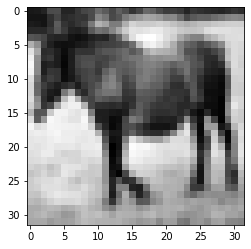

In [ ]:
Gray = cv2.cvtColor(x_train[7], cv2.COLOR_BGR2GRAY)
plt.imshow(Gray, cmap='gray')
testImageHeight  = Gray.shape[0]
testImageWidth = Gray.shape[1]
imageNChannels = 1
Gray.shape

## **[보충학습 : 엣지 이미지 검출 변환법]**

본 튜토리얼에서 학습한 바와 같이 "**scikit-image**"라는 이미지처리에 특화된 Python 이미지 라이브러리의 **sobel operator**를 사용하면 엣지이미지로 전처리할 수 있다.

이에 추가하여 OpenCV에서 제공하는 가장자리(Edge) 검출 방법과 Keras를 이용하여 Sobel Filter 성능을 간단하게 구현해본다.

**[OpenCV를 이용한 Edge 검출법]**

가장자리(Edge)는 가장 바깥 부분의 둘레를 의미하며, 객체의 테두리로 볼 수 있다.

이미지 상에서 가장자리는 전경(Foreground)과 배경(Background)이 구분되는 지점이며, 전경과 배경 사이에서 밝기가 큰 폭으로 변하는 지점이 객체의 가장자리가 된다. 그러므로 가장자리는 픽셀의 밝기가 급격하게 변하는 부분으로 간주할 수 있다.

가장자리를 찾기 위해 미분(Derivative)과 기울기(Gradient) 연산을 수행하며, 이미지 상에서 픽셀의 밝기 변화율이 높은 경계선을 찾는다.

In [ ]:
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

sobel = cv2.Sobel(gray, cv2.CV_8U, 1, 0, 3)
laplacian = cv2.Laplacian(gray, cv2.CV_8U, ksize=3)
canny = cv2.Canny(src, 100, 255)

cv2.imshow("sobel", sobel)
cv2.imshow("laplacian", laplacian)
cv2.imshow("canny", canny)
cv2.waitKey()
cv2.destroyAllWindows()

**세부 코드 (Sobel) 함수**

In [ ]:
sobel = cv2.Sobel(gray, cv2.CV_8U, 1, 0, 3)

소벨 함수(cv2.Sobel)로 입력 이미지에서 가장자리를 검출할 수 있다.

미분 값을 구할 때 가장 많이 사용되는 연산자이며, 인접한 픽셀들의 차이로 기울기(Gradient)의 크기를 구한다.

이때 인접한 픽셀들의 기울기를 계산하기 위해 컨벌루션 연산을 수행한다.

dst = cv2.Sobel(src, ddepth, dx, dy, ksize, scale, delta, borderType)은 입력 이미지(src)에 출력 이미지 정밀도(ddepth)를 설정하고 dx(X 방향 미분 차수), dy(Y 방향 미분 차수), 커널 크기(ksize), 비율(scale), 오프셋(delta), 테두리 외삽법(borderType)을 설정하여 결과 이미지(dst)를 반환한다.

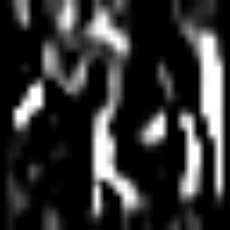

In [ ]:
gray = cv2.cvtColor(x_train[7], cv2.COLOR_BGR2GRAY)

sobel = cv2.Sobel(gray, cv2.CV_8U, 1, 0, 3)
#laplacian = cv2.Laplacian(gray, cv2.CV_8U, ksize=3)
#canny = cv2.Canny(src, 100, 255)

cv2_imshow(cv2.resize(sobel, (230, 230)))
#cv2.imshow("sobel", sobel)
#cv2.imshow("laplacian", laplacian)
#cv2.imshow("canny", canny)
#cv2.waitKey()
#cv2.destroyAllWindows()

다음으로 소벨 함수(cv2.Sobel)보다 성능이 좋은 **라플라시안 함수(cv2.Laplacian)**로 입력 이미지에서 가장자리를 검출해보았다.

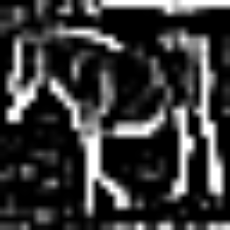

In [ ]:
gray = cv2.cvtColor(x_train[7], cv2.COLOR_BGR2GRAY)

#sobel = cv2.Sobel(gray, cv2.CV_8U, 1, 0, 3)
laplacian = cv2.Laplacian(gray, cv2.CV_8U, ksize=3)
#canny = cv2.Canny(src, 100, 255)

cv2_imshow(cv2.resize(laplacian, (230, 230)))
#cv2.imshow("sobel", sobel)
#cv2.imshow("laplacian", laplacian)
#cv2.imshow("canny", canny)
#cv2.waitKey()
#cv2.destroyAllWindows()

["**scikit-image**"의 **sobel operator** 성능비교]

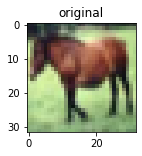

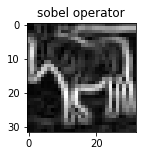

In [ ]:
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2gray

def sobel (image, thresold=180):
  grey_image = rgb2gray(image)
  convx = sobel_h(grey_image)
  convy = sobel_v(grey_image)
  output = np.sqrt(convx**2 + convy**2)
  return output

plt.figure(figsize=(2,2))
plt.imshow(x_train[7].astype('uint8'))
plt.title('original')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(sobel(x_train[7]), cmap=plt.cm.gray)
plt.title('sobel operator')
plt.show()

**[(horizontal) Sobel filter in Keras]**

(32, 32)

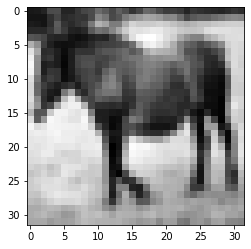

In [ ]:
matterhornGray = cv2.cvtColor(x_train[7], cv2.COLOR_BGR2GRAY)
plt.imshow(matterhornGray, cmap='gray')
testImageHeight  = matterhornGray.shape[0]
testImageWidth = matterhornGray.shape[1]
imageNChannels = 1
matterhornGray.shape

1/1 [==============================] - 0s 42ms/step


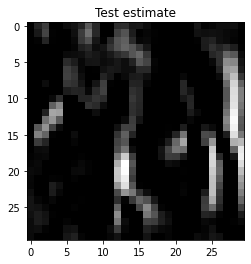

In [ ]:
# Sobel operator for horizontal edge detection
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
# Sobel operator for vertical edge detection
Ky = Kx.T

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU
from keras.regularizers import l1

tf.random.set_seed(2020)

model0 = Sequential([
    Conv2D(filters=1,kernel_size=(3,3), activation='relu', input_shape=(None, None, imageNChannels), use_bias=False, weights=Kx.reshape(1,3,3,1,1))])

testImage = matterhornGray.reshape(1, testImageHeight, testImageWidth, 1) / 255
testEst0 = model0.predict(testImage)
testEstEdges0 = (testEst0.reshape(testImageHeight-2, testImageWidth-2)) * 255

plt.figure(figsize=(4, 4))
plt.imshow(testEstEdges0, cmap='gray');
plt.title('Test estimate');

## 추가 참고자료 (Reference Plus)

- [이미지 처리 기초/데이터사이언스 스쿨](datascienceschool.net/03%20machine%20learning/03.02.01%20이미지%20처리%20기초.html)
- [OpenCV 문서](docs.opencv.org/4.x/index.html)
- [OpenCV강좌](https://076923.github.io/posts/Python-opencv-1/)
- [Edge detection with Convolutional Neural Network - Part 1](https://tonio73.github.io/data-science/cnn/CnnEdgeDetection-Keras-Part1.html)

---

- [cs231n](http://cs231n.github.io/)
- [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/)
- [Deep Learning with Python 2판 자료](https://codingalzi.github.io/dlp/)
- [Keras tutorial on CIFAR-10](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)
- [Sobel Edge Detector](https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm)
- [Edge detection, Wikipedia](https://en.wikipedia.org/wiki/Edge_detection)
- [Sobel operator, Wikipedia](https://en.wikipedia.org/wiki/Sobel_operator)
- [Image convolution examples, AI Shake](http://aishack.in/tutorials/image-convolution-examples/)
- [vexcel/Keras-LearnLinearFilter-github](https://github.com/vexcel/Keras-LearnLinearFilter)
- [Learning to perform linear filtering using natural image data](https://towardsdatascience.com/learning-to-perform-linear-filtering-using-natural-image-data-db289d0b0457)
- [A Beginner's Guide to Convolutional Neural Networks (CNNs), 김수현](https://towardsdatascience.com/a-beginners-guide-to-convolutional-neural-networks-cnns-14649dbddce8)
- [How to Develop a CNN From Scratch for CIFAR-10 Photo Classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)

---
- [TensorFlow for Computer Vision — How to Implement Convolutions From Scratch in Python](https://towardsdatascience.com/tensorflow-for-computer-vision-how-to-implement-convolutions-from-scratch-in-python-609158c24f82)
- [2D Convolution using Python & NumPy](https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381)
- [안경잡이개발자_Convolution 연산](https://ndb796.tistory.com/651)
- [딥러닝 직접 구현하기_cdjs의 코딩 공부방](https://cding.tistory.com/112)
- [누구나 이해할 수 있는 딥러닝 - cs231n 5강 (Convolutional Neural Networks, CNN)](https://cding.tistory.com/category/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5/%EB%88%84%EA%B5%AC%EB%82%98%20%EC%9D%B4%ED%95%B4%ED%95%A0%20%EC%88%98%20%EC%9E%88%EB%8A%94%20%EB%94%A5%EB%9F%AC%EB%8B%9D%28cs231n%29)
- [파이썬으로 딥러닝하기](https://everyday-deeplearning.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9C%BC%EB%A1%9C-%EB%94%A5%EB%9F%AC%EB%8B%9D%ED%95%98%EA%B8%B0-CNNConvolution-Neural-Network)
- [Implement Convolutional Layer in Python](https://meatba11.medium.com/implement-convolutional-layer-in-python-5ee4ceebc341)
- [Multi-Channel Convolutions explained with… MS Excel!](https://medium.com/apache-mxnet/multi-channel-convolutions-explained-with-ms-excel-9bbf8eb77108)
- [합성곱 연산 알고리즘](https://loklee9.tistory.com/156)
- [합성곱 신경망(CNN)](https://osh88itopia.tistory.com/95)
- [심층 합성곱 신경망으로 이미지 분류_gilbutITbook](https://github.com/gilbutITbook/007022/blob/master/code/ch15/ch15.ipynb)
- [데이터 사이언스 스쿨](https://datascienceschool.net/intro.html)
- [PyTorch로 시작하는 딥 러닝 입문](https://wikidocs.net/book/2788)


---
- [CNN 역전파를 이해하는 가장 쉬운 방법](https://metamath1.github.io/cnn/index.html)
